Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\mat}[1]{\begin{bmatrix} #1 \end{bmatrix}}$


# Exercício 4: Redes Neurais


# 1. Obtendo o conjunto de dados

Usaremos um conjunto de dados sintético produzido facilmente pela biblioteca `scikit-learn`. Os dados podem ser interpretados como uma versão ruidosa da função XOR.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn.datasets
import sklearn.metrics as skm
%matplotlib inline

In [2]:
def σ(z):
    z = np.clip(z,-500,500)
    return 1/(1+np.exp(-z))

def plotDataset(X, y):
    ### Plota todos os pontos contidos no dataset 
    y = y.flatten()
    plt.plot(X[y==0,0],X[y==0,1],'bo',X[y==1,0],X[y==1,1],'rx')

def plotBoundary(X, w, N=100):
    ### Plota a região de decisão do dataset
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), N)
    x2 = np.linspace(X[:,1].min(), X[:,1].max(), N)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.column_stack((xx1.reshape(-1),xx2.reshape(-1)))
    #X = mapFeature(X)
    y_hat = predict_class(w,X).reshape(xx1.shape)
    y_hat = (y_hat>=0.5)*2-1
    plt.contourf(xx1,xx2,y_hat,cmap=plt.cm.bwr,vmin=-5,vmax=5)

# 2. Estrutura do modelo

As funções de ativação, tanto da camada de saída quanto da camada oculta, devem ser do tipo sigmóide, $g(z) = \sigma(z)$.

Como consequência da sua estrutura, o modelo possui um total de 9 parâmetros:
- $\bW^{[1]} = \mat{{\bw_1^{[1]}}^T \\ {\bw_2^{[1]}}^T} = \mat{w_{1,1}^{[1]} & w_{1,2}^{[1]} \\ w_{2,1}^{[1]} & w_{2,2}^{[1]}}$
- $\bb^{[1]} = \mat{b_1^{[1]} \\ b_2^{[1]}}$
- $\bW^{[2]} = \mat{{\bw_1^{[2]}}^T} = \mat{w_{1,1}^{[2]} & w_{1,2}^{[2]}}$
- $\bb^{[2]} = \mat{b_1^{[2]}}$

Internamente, estes parâmetros devem estar representados como um único vetor 1-D, denotado por $\theta$:
$$
\theta = (w^{[1]}_{1,1},w^{[1]}_{1,2},w^{[1]}_{2,1},w^{[1]}_{2,2},b^{[1]}_{1},b^{[1]}_{2},w^{[2]}_{1,1},w^{[2]}_{1,2},b^{[2]}_{1})
$$

**Obs:** Ao contrário dos exercícios anteriores, aqui a matrix $\bX$ deve conter apenas os atributos originais, pois o termo de _bias_ ($\bb$) é representado separadamente no modelo da rede neural.

# 3. Implementando o modelo

O treinamento da rede neural, implementado pela função `train` fornecida abaixo, envolve os seguintes passos:

1. Inicialização dos parâmetros (vetor $\theta$)
2. Minimização da função custo

Note que, para este exercício, não é necessário normalizar os atributos.

A principal diferença para os exercícios anteriores é a opção `jac=True` na função `minimize`, que indica que o gradiente será calculado na própria função custo (como segundo objeto retornado) ao invés de uma função separada. Isto é importante para reduzir a complexidade, pois todos os passos necessários para calcular o custo são também realizados no cálculo do gradiente, e assim podem ser reaproveitados.

Portanto, a parte central da implementação está na função custo, sendo a etapa mais difícil o cálculo do gradiente, a qual é feita pelo método *backpropagation*. Este método consiste essencialmente da aplicação repetida da regra da cadeia do cálculo diferencial.

Para facilitar a implementação, neste exercício, não é necessário _vetorizar_ o código, isto é, você pode utilizar um laço sobre as amostras do conjunto de treinamento (`for i in range(m):`) para calcular tanto o custo quanto o gradiente.

**Dica:** inicialize $\bw_1^{[1]}$ e $\bw_2^{[1]}$ com valores _diferentes_, caso contrário seus valores tenderão a se manter idênticos durante todo o treinamento.

In [3]:
def train(X, y):
    theta = initialize_parameters()
    theta = opt.minimize(fun=cost, x0=theta, jac=True, args=(X,y), options={'maxiter': 500}).x
    return theta

def merge_parameters(W1, b1, W2, b2):
    merged = np.concatenate((W1[0].reshape(-1,1).T, W1[1].reshape(-1,1).T, b1.T, W2.T, b2.T),axis=1)
    return merged

def split_parameters(theta):
    theta = theta.reshape(-1,1)
    W1 = theta[:4]
    b1 = theta[4:6]
    W2 = theta[6:8]
    b2 = theta[-1:]
    W1 = np.array(W1).reshape(2,2)
    b1 = np.array(b1).reshape(2,1)
    W2 = np.array(W2).reshape(2,1)
    b2 = np.array(b2).reshape(1,1)
    return W1, b1, W2, b2

def initialize_parameters():
    W1 = np.random.rand(2,2)
    W2 = np.random.rand(2,1)
    b1 = np.random.rand(2,1)
    b2 = np.random.rand(1,1)
    return merge_parameters(W1, b1, W2, b2)

def cost(theta, X, y):
    m = X.shape[0]
    J = 0
    dJdW1_11 = 0
    dJdW1_12 = 0
    dJdW1_21 = 0
    dJdW1_22 = 0
    dJdB1_1  = 0
    dJdB1_2  = 0
    dJdW2_11 = 0
    dJdW2_21 = 0
    dJdB2_1  = 0
    dJdW1 = 0
    dJdB1 = 0
    dJdW2 = 0
    dJdB2 = 0
    # Split theta into W1, b1, W2, b2
    W1, b1, W2, b2 = split_parameters(theta)
    
    for i in range(m):    
        # Forward propagation: compute z1, a1, z2, a2
        a0 = X[i].reshape(-1,1) # reshape to not bug
        z1 = W1 @ a0 + b1
        a1 = σ(z1)
        z2 = W2.T @ a1 + b2
        a2 = σ(z2)
        y_hat = a2[0][0]
        # Cost: compute J
        yi = y[i][0]
        J += -yi*np.log(y_hat)-(1 - yi+1e-20)*np.log(1 - y_hat+1e-20)

        # Back propagation: compute dJ/dz2, dJ/dW2, dJ/db2, dJ/da1, dJ/dz1, dJ/dW1, dJ/db1
        dJdW1_11 += (y_hat - y[i])*W1[0][1]*a1[0]*(1-a1[0])*a0[0]
        dJdW1_12 += (y_hat - y[i])*a1[0]
        dJdW1_21 += (y_hat - y[i])*W1[0][1]*a1[0]*(1-a1[0])*a0[1]
        dJdW1_22 += (y_hat - y[i])*a1[1]
        dJdB1_1  += (y_hat - y[i])*W1[0][1]*a1[0]*(1-a1[0])
        dJdB1_2  += (y_hat - y[i])
        dJdW2_11 += (y_hat - y[i])*W1[1][1]*a1[1]*(1-a1[1])*a0[0]
        dJdW2_21 += (y_hat - y[i])*W1[1][1]*a1[1]*(1-a1[1])*a0[1]
        dJdB2_1  += (y_hat - y[i])*W1[1][1]*a1[1]*(1-a1[1])
    
    # Merge dJ/dW1, dJ/db1, dJ/dW2, dJ/db2 into grad = dJ/dtheta
    dJdW1 = np.array(([dJdW1_11[0], dJdW1_12[0]], [dJdW1_21[0], dJdW1_22[0]]))
    dJdB1 = np.array(([dJdB1_1[0]],[dJdB1_2[0]]))
    dJdW2 = np.array(([dJdW2_11[0]],[dJdW2_21[0]]))
    dJdB2 = np.array(dJdB2_1).reshape(-1,1) # reshape to not bug
    
    grad = merge_parameters(dJdW1, dJdB1, dJdW2, dJdB2)*(1/m)
    grad = grad[0] #unidmentional array for the optimize
    
    J = J/m
    
    return J, grad
def predict_class(theta, X):
    [W111, W121, B11, W211, W221, B21, W112, W122, B12] = theta
    y_pred = []
    for i in range(X.shape[0]):
        z0 = W111*X[i][0] + W121*X[i][1] + B11
        z1 = W211*X[i][0] + W221*X[i][1] + B21
        a0 = σ(z0)
        a1 = σ(z1)
        z2 = W112*a0 + W122*a1 + B12
        y_hat = σ(z2)
        y_pred.append((y_hat > 0.5).astype(float))
    return np.array(y_pred)


# 4. Predição

Avalie a acurácia do modelo no conjunto de treinamento. Você conseguiu obter 100% de acurácia?

Experimente alterar o parâmetro `cluster_std` na geração do conjunto de dados para verificar como o modelo se comporta, bem como alterar o número de amostras. Você pode também alterar o número de iterações no treinamento.

Note que, se desejar usar as funções plotDataset e plotBoundary, estas devem ser adaptadas ao formato usado para a matrix $\bX$ e à função de predição do modelo.

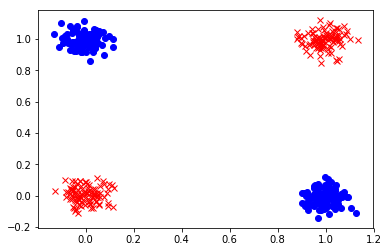

In [4]:
m = 400
centers = [[0,0],[0,1],[1,1],[1,0]]
X,y = sklearn.datasets.make_blobs(n_samples=m, n_features=2, centers=centers, cluster_std=0.05, random_state=0)
y = (y % 2 == 0).astype(float)
plt.plot(X[y==0,0],X[y==0,1],'bo',X[y==1,0],X[y==1,1],'rx')

In [5]:
y = y.reshape(-1,1)
X.shape, y.shape

((400, 2), (400, 1))

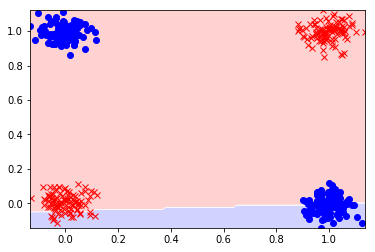

In [6]:
theta = train(X,y)
y_pred = predict_class(theta, X)
plotDataset(X,y)
plotBoundary(X,theta)

In [7]:
skm.accuracy_score(y, y_pred)*100

60.25

In [ ]:
# tentei ver com o pessoal da sala pra tentar melhorar e não consegui, perdão